NOTE for the instructor: magnitude, flux, distance modulus, calibration

# This notebook is intended to show how to calibrate an image, and measure an object's Magnitude!

## Overview from last time:

* Opening a fits image
* Plotting the image
* Finding all of the objects in the image

Let's start with all of the imports we will need today, along with our inline plotting `magic` function. 

In [11]:
#this gives us access to numpy as np, and matplotlib.pyplot as plt
%pylab inline

#Astronomical imports!... exotic
from astropy.io import fits
from astropy import wcs as wcs
import sep


Populating the interactive namespace from numpy and matplotlib


# Opening an image
 <font color='blue'> Exercise: let's read an image as we learned in previous lectures and let's define the data and the header:
</font>

Hints: 
* our file is the same as last time `16335757.fits`
* we use the astropy.io function: `fits.open(filename)` to open the file
* this returns an HDU list, our data and header will be in the 0th item in this list (`list[0].data, list[0].header`)
* lets call them `img` and `header` respectively

<font color='blue'> Plot your img data! </font>
* using `plt.imshow(img)` 

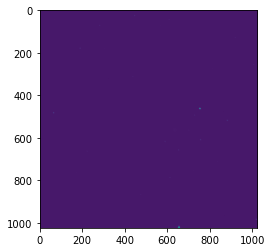

In [12]:
hdu_list = fits.open('16335757.fits')

img = hdu_list[0].data
header= hdu_list[0].header

plt.imshow(img)

### Now, let's plot a histogram of the image data, to see the range of its values

* We will use the matplotlib.pyplot (`plt`) histogram function: `plt.hist(x, bins)`
* Our data isn't in the correct format, we will convert it to a 1D list by using `img.flatten()`
* We will define it as having 100 bins as well

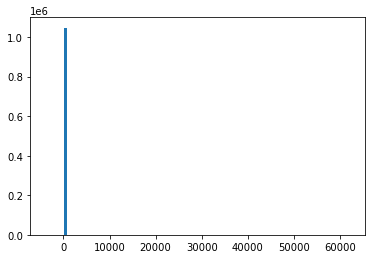

In [13]:
image_hist = plt.hist(img.flatten(), bins=100)

### Let's do it again, but this time constraining the range of the histogram  

* using <font color='blue'>range=(X,Y) </font> inside the `plt.hist()` method

* <font color='blue'>Can someone estimate values to put as the limits to the range? 0-10000? Less or more?</font>

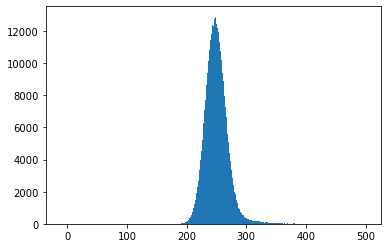

In [14]:
image_hist = plt.hist(img.flatten(), bins=1000, range=(-10,500))

### Now that we have an idea where our data is, let's redo the plot with these parameters

* We can constrain our `plt.imshow()` by using the `vmin` and `vmax` parameters.
* <font color='blue'> Judging by the above histogram, what are some good values to use here?</font>

`imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=??, vmax=??)`

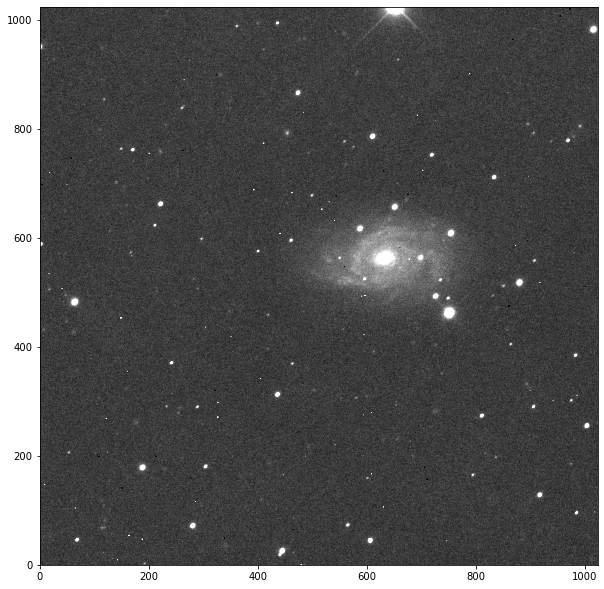

In [15]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=200, vmax=400)

## Beautiful!


### Now lets find the position of all the stars in the image.

* For this we will use a package called: <font color='red'>sep</font> which was used last lecture
* We will have to define the background of the image, then use that information to locate the objects with `sep`


The 3 command we need to use are the following:
<br> <font color='blue'>  img = img.byteswap().newbyteorder()</font>
<br> <font color='blue'>  bkg = sep.Background(img)</font>
<br> <font color='blue'>  objects = sep.extract(img, thresh=20.0, err=bkg.globalrms, mask=None, minarea=10, clean=True, clean_param=1.0, segmentation_map=False)</font>

In [16]:
img = img.byteswap().newbyteorder() # magic command
bkg = sep.Background(img)
img_sub = img-bkg
objects = sep.extract(img, 
                      thresh=20.0, 
                      err=bkg.globalrms, 
                      mask=None, 
                      minarea=10, 
                      clean=True, 
                      clean_param=1.0, 
                      segmentation_map=False
                    )



### Now let's plot the objects that sep extracted

* objects is a NumPy structured array with many fields. We have seen in the previous lecture where the source detections are stored. 

EXERCISE:
<font color='blue'> plot the extracted object on the image </font>

Hints:
* our x,y values are stored in `objects['x'], objects['y']` respectively

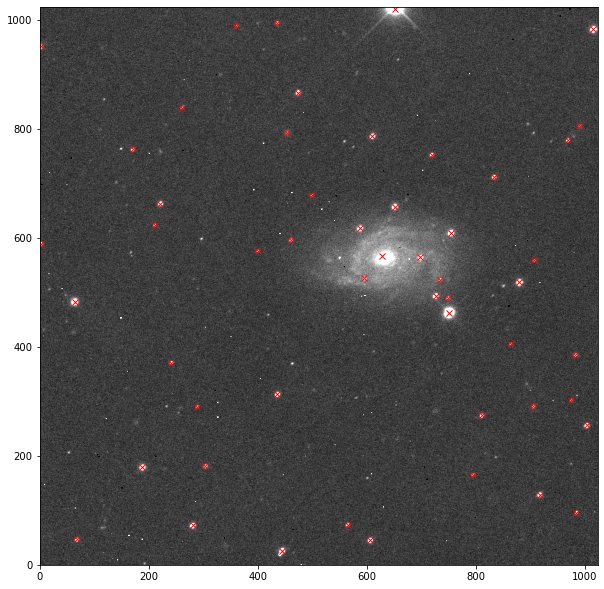

In [17]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=200, vmax=400)
plt.plot(objects['x'],objects['y'],'xr')

# World Coordinate System (WCS)

If we know the sky coordinates of one interesting object, how can we find its position in the image?
To do that we can use the information on the header of the file and convert the coordinate in pixel position using the [wcs](https://docs.astropy.org/en/stable/wcs/) package in astropy. 

In [18]:
# import the wcs package
from astropy.wcs import WCS


In the next cell, we'll read the WCS information from the image header. 

In [19]:
#We already read the header above, but we can do it again here if needed (uncomment the line below).
#header = hdu_list[0].header

# read in the WCS solution from the header
w = WCS(header)
#transform coordinate in pixels:
Ra = 148.283666667
Dec = 16.7139583333
px, py = w.wcs_world2pix(Ra,Dec, 1)
print('my object should be close to these coordinate')
print(px,py)


my object should be close to these coordinate
611.6228472316652 786.023106657171


Let's plot the image again, and this time mark the position of the star in the image. 

* <font color='blue'>Fill in the last plotting command to mark the star of interest, using a different plotting symbol and color.</font>

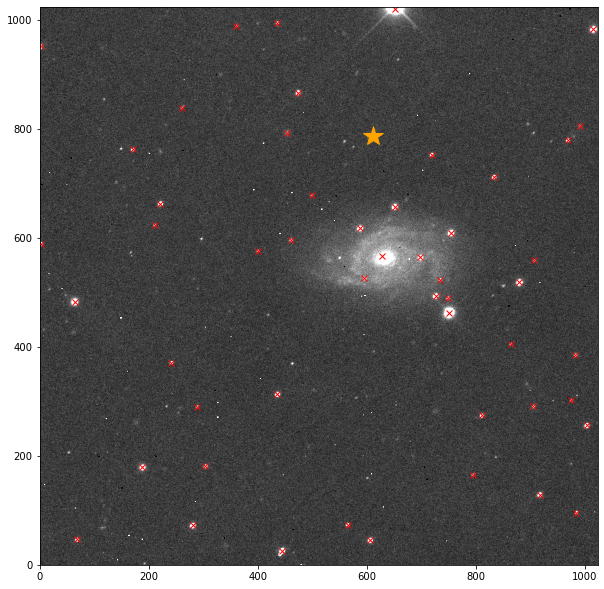

In [20]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=200, vmax=400)
plt.plot(objects['x'],objects['y'],'xr')

plt.plot(611,786,'*',color='orange',markersize=20)

Now we want to identify which object in the dictionary is our object. We need to compare the pixel position for each object in the object dictionary with the pixel position we found. We need to measure the distance between them and take the object if the distance is less than XX pixels. Let's loop over the stars using enumerate and compute the difference between the coordinates until we find an object that is close enough. 


`enumerate` is useful when you want to use a counting variable in a loop. It allows you to loop over something and have an automatic counter. Here are some examples of how it works:

In [24]:
#Just a regular loop through a list
values = ['a', 'b', 'c']
for value in values:
    print(value)
    

a
b
c


In [22]:
#what happens if we use enumerate:
for value in enumerate(values):
    print(value)
    

(0, 'a')
(1, 'b')
(2, 'c')


You can break-up the counting variable from the corresponding list elements by providing two variables in the loop. 

In [23]:
for count, value in enumerate(values):
    print(count, value)
    

0 a
1 b
2 c


EXERCISE:
<font color='blue'> Loop throught the objects dictionary to find the object that is close to our object of interest.</font>

Hints:
* The x,y values are stored in `objects['x'], objects['y']`, respectively. 
* The x,y values for our object of interst are stored in `px, py`, respectively
* Recall the formula for the distance between two points: sqrt((x1 - x2)^2 + (y1 - y2)^2)
* You can use a distance threshold of 10 pixels to decide if an object is close enough. 



In [17]:
for i,j in enumerate(objects['x']):
    distance = np.sqrt((objects['x'][i]-px)**2+(objects['y'][i]-py)**2)
    print('distance ', distance)
    if distance < 10:
        print('FOUND', i)
        print('The coordinate is', objects['x'][i], objects['y'][i])
        break
        
        

distance  778.6005470163343
distance  918.4377214525197
distance  741.5085177861647
distance  714.4150348367656
distance  787.4898644860796
distance  784.7679373488967
distance  724.9768611048848
distance  647.3452294889049
distance  740.5879932301043
distance  679.2701780446961
distance  659.5254528291221
distance  549.6227140924582
distance  592.0127868708779
distance  576.2243516573914
distance  605.199997643066
distance  505.07364166899026
distance  556.5577483687035
distance  546.5243256263238
distance  456.74656941863003
distance  352.471923743342
distance  626.7303976658332
distance  326.6739341836758
distance  314.4467191006341
distance  379.0500456345646
distance  290.3753991419198
distance  261.421895843736
distance  372.93822077066704
distance  238.5449527637028
distance  298.3867005923684
distance  640.9051736147348
distance  243.2666197466133
distance  221.19377981738364
distance  227.34142737033721
distance  170.7276246374637
distance  433.19759849841216
distance  135.132

# Photometry and Flux
Now what we want to do with these objects? We probably want to measure how much light is emitted by each of them.

Let's zoom on one of them by cutting a small box of 40 x 40 pixels with one object in the center.Tto cut a region we should do  <font color='blue'> img[a:b,c:d] </font> with a,b,c,d the pixels (integer) at the edges of the small matrix. 

* let's do that for the element 10 of the object dictionary. `object['x'][10]` and `object['y'][10]`

* let's now plot the zoomed image!



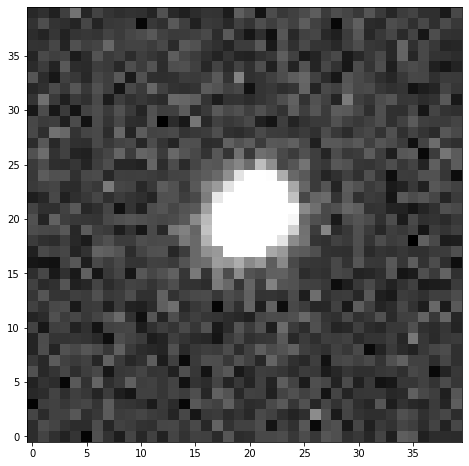

In [25]:
obj_10_y = int(objects['y'][10])
obj_10_x = int(objects['x'][10])

#The entire slice! -20 and + 20 all around this object from the image data
obj_10 = img[
    obj_10_y-20:obj_10_y+20,
    obj_10_x-20:obj_10_x+20
  ] 

fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
imgshow = ax.imshow(obj_10, origin='lower', cmap='gray', vmin=200, vmax=400)

### How do we define where the star `begins` or `ends`??

Let's do a test!

We want to see the amount of flux at a given radius going out from the center of the circle. I will define the `edge` of my star where the amount of flux stops growing.

* We can utilize the `sep.sum_circle()` function to find the amount of flux inside a given radius
* Below, we iterate radii from 1-20 pixels from the center of our star, and plot the flux.
* here we use the background-subtracted image: `img_sub`



Text(0, 0.5, 'flux (counts)')

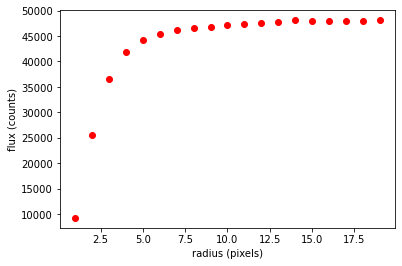

In [27]:
fluxvec = []
radiuscev = []
for radius in range(1,20):
    flux, fluxerr, flag = sep.sum_circle(img_sub, [objects['x'][10]], [objects['y'][10]],
                                         radius, err=bkg.globalrms, gain=1.0)
    fluxvec.append(flux)
    radiuscev.append(radius)

plt.plot(radiuscev,fluxvec,'or')
plt.xlabel('radius (pixels)')
plt.ylabel('flux (counts)')



Let's select the region to get all the counts of the object. We can use a circle.

<font color='blue'> From the plot above: How large should be the radius? </font>

EXERCISE:

* <font color='blue'> Lets plot 3 circles of different radii (8,10,12) around our object to get an idea where the flux is coming from.</font>

Hint:

* To plot a circle you will first need to define a matplotlib `Circle` object and then add it to your ax patches like so:

```
c1 = Circle((x,y),radius, color='r', lw=4, fill=False)
ax.add_patch(c1)
```

* here (x,y) will be the center of our star (20, 20)
* lw - stands for linewidth, let's leave it at 4 pixels wide
* fill=False, we leave this at false. If true, it will plot an full colored circle, not just a ring.


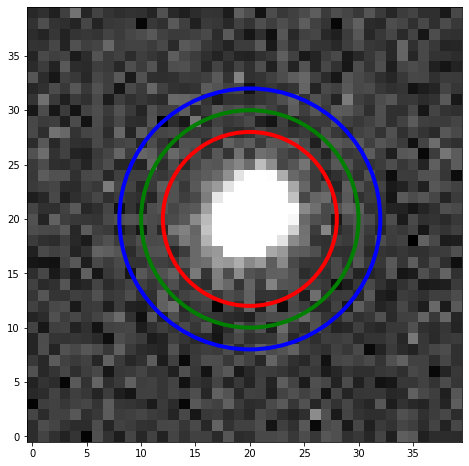

In [28]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
imgshow = ax.imshow(obj_10, origin='lower', cmap='gray', vmin=200, vmax=400)
circ = Circle((20,20),8 ,color='r', lw=4, fill=False)
ring1 = Circle((20,20),10 ,color='g',lw=4, fill=False)
ring2 = Circle((20,20),12 ,color='b',lw=4, fill=False)
ax.add_patch(circ)
ax.add_patch(ring1)
ax.add_patch(ring2)



### Now that we have defined the "Edge" of our star, Lets get its flux!

EXERCISE: <font color='blue'>Measuring Flux of our object</font>
* using the sep.sum_circle() method from above obtain the flux and error from our 10th element object
* `flux, fluxerr, flag = sep.sum_circle(img_sub, [x], [y], radius, err=bkg.globalrms, gain=1.0)`



In [29]:
flux, fluxerr, flag = sep.sum_circle(img_sub, [objects['x'][10]], [objects['y'][10]],
                                         10, err=bkg.globalrms, gain=1.0)

print(flux)



[47091.98190247]


### To clarify:

* What we have just measured is the number of counts within a radius of ?? pixel(s) for one object we selected in the image. 
* How do we use this measurement in astronomy? We usually convert this measurment into a magnitude, and if we know how our telescope is performing, then we know how bright a star appears to be. How bright actually is (absolute magnitude) depends on how far the star is. 

### Magnitudes!
* <font color='blue'> Let's first convert the flux into an instrumental magnitude. </font> 
* The equation we will use is `inst_mag = -2.5*np.log10(flux)`
* print it out!


In [30]:
inst_mag = -2.5 *np.log10(flux[0])
print('instrumental magnitude ', inst_mag)


instrumental magnitude  -11.682367421115941


### We are not done yet...

* We still need to transform this 'instrumental magnitude' into a calibrated apparent magnitude. This value will actually mean something astronomically, in comparison with a standardized magnitude system. 

* In order to do this primary calibration, we need to know the apparent magnitude of at least one object in the field... a <b>standard star</b>! 

* We need to measure its instrumental magnitude and subtract it from its known apparent magnitude and obtain what we call the "<b>zeropoint</b>".

* Once we have the zeropoint, we can measure the magnitudes of any object in the image by adding it to the instrumental magnitude!

EXERCISE: <font color='blue'> Measuring the zeropoint. </font>

* <font color='blue'> I know the apparent magnitude of the 9th element of our objects is 15, using the code above calculate the zeropoint for our image </font>

HINTS:

* Copy the code above and calculate inst_mag using the sep.sum_circle() function on the 9th element of our objects list, you can keep the radius at 10.
* `zeropoint = app_mag - inst_mag; (app_mag = 15)`
    
    

In [31]:
# instrumental magnitude for object[9]
flux9, fluxerr9, flag9 = sep.sum_circle(img_sub, [objects['x'][9]], [objects['y'][9]],
                                         10, err=bkg.globalrms, gain=1.0)
inst_mag9 = -2.5 *np.log10(flux9[0])
app_mag9 = 15 
zero_point = app_mag9 - inst_mag9
print('the zeropoint of the image is', zero_point)


the zeropoint of the image is 25.38090805363596


### The final goal! 

* <font color='blue'> Now that you know the zeropoint of the image, calculate the apparent magnitude of our star of interest! </font>

HINT:

* `app_mag = zeropoint + inst_mag`


In [32]:
app_mag10 = inst_mag + zero_point
print(app_mag10)


13.698540632520018


# Distance modulus

* We have learned that knowing the apparent and absolute magnitudes can give us a distance to the source (Distance Modulus).

* `distance_modulus = apparent_mag - absolute_mag`

* <font color='blue'>What if we already knew the distance modulus to a star in our image above? What information could we get from what we learned today? </font>

* Knowning the absolute magnitude of an object is important for initial supernova discoveries. For example, this can can give us a guess of its type before we even have a spectrum.

* <font color='blue'> If we knew the distance modulus to our image as: `30 mag`. What would be the absolute magnitude of our star? </font>


In [33]:
abs_mag = app_mag10 - 30
print(abs_mag)

-16.301459367479982
